In [3]:
!gdown --id 1Pjr69ChG81L2KEQLPs-dA6eW4RUCkBsD

Downloading...
From: https://drive.google.com/uc?id=1Pjr69ChG81L2KEQLPs-dA6eW4RUCkBsD
To: C:\Faaiq\Course Resources\Semester 4\Machine Learning\Assignment 4\PA4_dataset.zip

  0%|          | 0.00/322k [00:00<?, ?B/s]
100%|##########| 322k/322k [00:00<00:00, 583kB/s]
100%|##########| 322k/322k [00:00<00:00, 583kB/s]


In [4]:
# !unzip PA4_dataset.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


Loaded dataset, pre-processing now

In [1]:
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import math
import os
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import classification_report

In [2]:
dataset_test = pd.read_csv("PA4_dataset/test.csv")
dataset_train = pd.read_csv("PA4_dataset/train.csv")
stop_words_doc = pd.read_csv("PA4_dataset/stop_words.txt", header=None)
stop_words = stop_words_doc[0][:]

In [3]:
# separating the sentiment data and the tweet content
test_sentiment = dataset_test.iloc[:,0]
train_sentiment = dataset_train.iloc[:,0]
test_tweets = dataset_test.iloc[:,1]
train_tweets = dataset_train.iloc[:,1]

# Part 1: Preprocessing

In [4]:
# Beginning preprocessing
# modulating by making function instead
def cleaning_data(dataframe, stopwords):
    clean_list = []
    for tweet in dataframe:
        temp_string = tweet
        # removing stop words
        for word in stopwords:
            word = " "+word
            temp_string = re.sub(word,'',temp_string) 
        # remove hyperlinks
        temp_string = re.sub('http[s]?://\S+', '', tweet)
        # remove numbers
        temp_string = re.sub(r'[0-9]+', '', temp_string)
        # remove usernames
        temp_string = re.sub('@\S+','',temp_string)
        # remove all punctuation
        temp_string = re.sub(r'[^\w\s]', '', temp_string)
        # done removing, add back to original list
        temp_string = temp_string.lower()
        clean_list.append(temp_string)
    return clean_list

In [5]:
# for Naive Bayes
# it is common to not remove stop words, hence we we will make a function that does everything, but does not remove stop words
def cleaning_data_wsw(dataframe): # with stop words
    clean_list = []
    for tweet in dataframe:
        temp_string = tweet
        # remove hyperlinks
        temp_string = re.sub('http[s]?://\S+', '', tweet)
        # remove numbers
        temp_string = re.sub(r'[0-9]+', '', temp_string)
        # remove usernames
        temp_string = re.sub('@\S+','',temp_string)
        # remove all punctuation
        temp_string = re.sub(r'[^\w\s]', '', temp_string)
        # done removing, add back to original list
        temp_string = temp_string.lower()
        clean_list.append(temp_string)
    return clean_list

clean_sw_train = cleaning_data_wsw(train_tweets)
clean_sw_test = cleaning_data_wsw(test_tweets)

In [6]:
# pd.set_option("display.max_rows", None, "display.max_columns", None)
# pd.reset_option("all")
print(test_tweets)

0       @USAirways thanks to the whole team for an on-...
1       @VirginAmerica gives positive outlook, but see...
2       @JetBlue Hey Jetblue, you Cancelled Flightled ...
3       @united @PGATOUR @NTrustOpen Next thing you kn...
4       @SouthwestAir why can't you help me after you ...
                              ...                        
1459    @AmericanAir after waiting for a delayed plane...
1460    @VirginAmerica what is going on with customer ...
1461    @SouthwestAir I will tell marry a lamp if you ...
1462    @USAirways I got an email asking me to checkin...
1463        @USAirways @AmericanAir no, don't leave me!!!
Name: Tweet, Length: 1464, dtype: object


In [7]:
clean_test_tweets = cleaning_data(test_tweets, stop_words)
clean_train_tweets = cleaning_data(train_tweets, stop_words)

Data Preprocessing done.
Removed the following in order: 


*   Stop words first, as they contained punctuation.
*   All usernames (everything starting with @)
*   Punctuation
*   Lowercase



# Part 2: Bag of Words


In [35]:
# Construct a vocabulary of all the words first
def vocabulary_construction(dataset):
    vocab = []
    for string in dataset:
        string_split = string.split()
        for word in string_split:
            if word not in vocab:
                vocab.append(word)
    return vocab
# run given function to produce training vocabulary
train_vocab = vocabulary_construction(clean_train_tweets)
train_vocab_wsw = vocabulary_construction(clean_sw_train)

In [9]:
num_train_tweets = len(clean_train_tweets)
num_test_tweets = len(clean_train_tweets)

def populate_bog(dataset, vocab):
    vocab_size = len(vocab)
    dataset_size = len(dataset)
    bag_of_words = np.zeros((dataset_size, vocab_size), dtype='int')
    for i in range(dataset_size):
        current_tweet = dataset[i].split()
        for word in current_tweet:
            try:
                position = vocab.index(word)
#                 bag_of_words[i,position] += 1
#                 print(bag_of_words[i][position])
                bag_of_words[i][position] += 1
#                 print(bag_of_words[i][position])
            except:
                pass
    return bag_of_words

# running to generate bag of words for test and training datasets
train_bog = populate_bog(clean_train_tweets, train_vocab)
test_bog = populate_bog(clean_test_tweets, train_vocab)

train_bog_wsw = populate_bog(clean_sw_train, train_vocab)
test_bog_wsw = populate_bog(clean_sw_test, train_vocab)

# Part 3: Logistic Regression from Scratch

In [20]:
def sigmoid_function(x_vector, weight_vector):
    z_value = np.dot(x_vector, weight_vector)
#     z_value += weight_vector[0]
    to_return = 1/(1+np.exp(-1*z_value))
    return to_return

In [11]:
# cross entropy function calls sigmoid function
def cross_entropy_loss(label_set, input_dataset, weight_vector):
    sum = 0
    bias = weight_vector[0]
    label_size = len(label_set)
    for i in range(label_size):
        x_vector = input_dataset[i]
        y_label = label_set[i]
        hypothesis_value = sigmoid_function(x_vector, weight_vector) # using first index onwards of the actual weight vector, as the 0th index has the bias value
        current_value = y_label*np.log(hypothesis_value)+(1-y_label)*np.log(1-hypothesis_value)
        sum += current_value
    return -1*sum

In [12]:
# preparing dataset for logistic regression
# making label vector for every case
def label_preparation(label, dataset):
    label_list = []
    for datapoint in dataset:
        if datapoint == label:
            label_list.append(1)
        else:
            label_list.append(0)
    return label_list

neg_train_label_list = label_preparation('negative', train_sentiment)
pos_train_label_list = label_preparation('positive', train_sentiment)
neut_train_label_list = label_preparation('neutral', train_sentiment)

neg_test_label_list = label_preparation('negative', test_sentiment)
pos_test_label_list = label_preparation('positive', test_sentiment)
neut_test_label_list = label_preparation('neutral', test_sentiment)

In [13]:
# training using gradient descent
def gradient_descent(initial_weights, dataset, label_vector, regular_param, epochs, lr):
    # lr is learning rate
    current_weights = initial_weights
    for epoch in range(epochs):
        sum = 0
        bias = 0
        for index, x_vector in enumerate(dataset):
            expression = sigmoid_function(x_vector, current_weights)
            label = label_vector[index]
            expression -= label
            bias_delta = expression
            expression = expression*x_vector
            sum += expression
            bias += bias_delta
        sum += 2*regular_param*current_weights[1:]
        bias += 2*regular_param*current_weights[0]
        current_weights[1:] = current_weights[1:] - lr*expression
        current_weights[0] = current_weights[0] - lr*bias 
    return current_weights

In [14]:
def gradient_descent_vectorized(initial_weights, dataset, label_vector, regular_param, epochs, lr):
    current_weights = initial_weights
    for epoch in range(epochs):
        expression_vector = sigmoid_function(dataset, current_weights)
        expression_vector -= label_vector
        bias = np.sum(expression_vector)
        product = np.multiply(expression_vector, dataset.transpose())
        sum = np.sum(product, axis=1)
        delta_weights = sum + 2*regular_param*current_weights
        # delta_bias = bias + 2*regular_param*current_weights[0]
        # current_weights[1:] = current_weights[1:] - lr*delta_weights
        # current_weights[0] - current_weights[0] - lr*delta_bias
        current_weights = current_weights - lr/len(label_vector)*delta_weights
    return current_weights

In [15]:
def predict(dataset, weight_matrix):
    predicted_labels = []
    for x_vector in dataset:
        predictions_list = []
        for weight_vector in weight_matrix:
            predictions_list.append(prediction_helper(x_vector, weight_vector))
        predicted_label = predictions_list.index(max(predictions_list))
        predicted_labels.append(predicted_label)
    return predicted_labels

In [16]:
def prediction_helper(x_vector, weight_vector):
    resulting_probability = np.dot(x_vector, weight_vector)
#     resulting_probability += 1*weight_vector[0]
    return resulting_probability

## Training the model

In [17]:
label_set = []
label_set.append(neg_train_label_list)
label_set.append(neut_train_label_list)
label_set.append(pos_train_label_list)
# neg,neut, pos = log_reg_training(train_bog, label_set, 1000, 0.01, 0.1)

In [18]:
def log_reg_training(dataset, label_set, epochs, lr, regular_param):
    initial_weights = np.zeros(len(dataset[0]))
    negative_weights = gradient_descent_vectorized(initial_weights, dataset, label_set[0], regular_param, epochs, lr)
    # print('done with negative')
    neutral_weights = gradient_descent_vectorized(initial_weights, dataset, label_set[1], regular_param, epochs, lr)
    # print('done with neutral')
    positive_weights = gradient_descent_vectorized(initial_weights, dataset, label_set[2], regular_param, epochs, lr)
    # print('done with positive')
    weights_set = []
    weights_set.append(negative_weights)
    weights_set.append(neutral_weights)
    weights_set.append(positive_weights)
    return weights_set

In [25]:
# computing all with 1000 epochs
e1000_set1 = log_reg_training(train_bog, label_set, 1000, 0.0001, 1)
e1000_set2 = log_reg_training(train_bog, label_set, 1000, 0.001, 1)
e1000_set3 = log_reg_training(train_bog, label_set, 1000, 0.01, 1)
e1000_set4 = log_reg_training(train_bog, label_set, 1000, 0.1, 1)
e1000_set5 = log_reg_training(train_bog, label_set, 1000, 0.0001, 10)
e1000_set6 = log_reg_training(train_bog, label_set, 1000, 0.001, 10)
e1000_set7 = log_reg_training(train_bog, label_set, 1000, 0.01, 10)
e1000_set8 = log_reg_training(train_bog, label_set, 1000, 0.1, 10)
e1000_set9 = log_reg_training(train_bog, label_set, 1000, 0.0001, 0.1)
e1000_set10 = log_reg_training(train_bog, label_set, 1000, 0.001, 0.1)
e1000_set11 = log_reg_training(train_bog, label_set, 1000, 0.01, 0.1)
e1000_set12 = log_reg_training(train_bog, label_set, 1000, 0.1, 0.1)


In [24]:
# computing all with 800 epochs
e800_set1 = log_reg_training(train_bog, label_set, 800, 0.0001, 1)
e800_set2 = log_reg_training(train_bog, label_set, 800, 0.001, 1)
e800_set3 = log_reg_training(train_bog, label_set, 800, 0.01, 1)
e800_set4 = log_reg_training(train_bog, label_set, 800, 0.1, 1)
e800_set5 = log_reg_training(train_bog, label_set, 800, 0.0001, 10)
e800_set6 = log_reg_training(train_bog, label_set, 800, 0.001, 10)
e800_set7 = log_reg_training(train_bog, label_set, 800, 0.01, 10)
e800_set8 = log_reg_training(train_bog, label_set, 800, 0.1, 10)
e800_set9 = log_reg_training(train_bog, label_set, 800, 0.0001, 0.1)
e800_set10 = log_reg_training(train_bog, label_set, 800, 0.001, 0.1)
e800_set11 = log_reg_training(train_bog, label_set, 800, 0.01, 0.1)
e800_set12 = log_reg_training(train_bog, label_set, 800, 0.1, 0.1)


In [23]:
# computing all with 500 epochs
e500_set1 = log_reg_training(train_bog, label_set, 500, 0.0001, 1)
e500_set2 = log_reg_training(train_bog, label_set, 500, 0.001, 1)
e500_set3 = log_reg_training(train_bog, label_set, 500, 0.01, 1)
e500_set4 = log_reg_training(train_bog, label_set, 500, 0.1, 1)
e500_set5 = log_reg_training(train_bog, label_set, 500, 0.0001, 10)
e500_set6 = log_reg_training(train_bog, label_set, 500, 0.001, 10)
e500_set7 = log_reg_training(train_bog, label_set, 500, 0.01, 10)
e500_set8 = log_reg_training(train_bog, label_set, 500, 0.1, 10)
e500_set9 = log_reg_training(train_bog, label_set, 500, 0.0001, 0.1)
e500_set10 = log_reg_training(train_bog, label_set, 500, 0.001, 0.1)
e500_set11 = log_reg_training(train_bog, label_set, 500, 0.01, 0.1)
e500_set12 = log_reg_training(train_bog, label_set, 500, 0.1, 0.1)


In [22]:
# computing all with 200 epochs
e200_set1 = log_reg_training(train_bog, label_set, 200, 0.0001, 1)
e200_set2 = log_reg_training(train_bog, label_set, 200, 0.001, 1)
e200_set3 = log_reg_training(train_bog, label_set, 200, 0.01, 1)
e200_set4 = log_reg_training(train_bog, label_set, 200, 0.1, 1)
e200_set5 = log_reg_training(train_bog, label_set, 200, 0.0001, 10)
e200_set6 = log_reg_training(train_bog, label_set, 200, 0.001, 10)
e200_set7 = log_reg_training(train_bog, label_set, 200, 0.01, 10)
e200_set8 = log_reg_training(train_bog, label_set, 200, 0.1, 10)
e200_set9 = log_reg_training(train_bog, label_set, 200, 0.0001, 0.1)
e200_set10 = log_reg_training(train_bog, label_set, 200, 0.001, 0.1)
e200_set11 = log_reg_training(train_bog, label_set, 200, 0.01, 0.1)
e200_set12 = log_reg_training(train_bog, label_set, 200, 0.1, 0.1)


In [21]:
# computing all with 100 epochs
e100_set1 = log_reg_training(train_bog, label_set, 100, 0.0001, 1)
e100_set2 = log_reg_training(train_bog, label_set, 100, 0.001, 1)
e100_set3 = log_reg_training(train_bog, label_set, 100, 0.01, 1)
e100_set4 = log_reg_training(train_bog, label_set, 100, 0.1, 1)
e100_set5 = log_reg_training(train_bog, label_set, 100, 0.0001, 10)
e100_set6 = log_reg_training(train_bog, label_set, 100, 0.001, 10)
e100_set7 = log_reg_training(train_bog, label_set, 100, 0.01, 10)
e100_set8 = log_reg_training(train_bog, label_set, 100, 0.1, 10)
e100_set9 = log_reg_training(train_bog, label_set, 100, 0.0001, 0.1)
e100_set10 = log_reg_training(train_bog, label_set, 100, 0.001, 0.1)
e100_set11 = log_reg_training(train_bog, label_set, 100, 0.01, 0.1)
e100_set12 = log_reg_training(train_bog, label_set, 100, 0.1, 0.1)


In [53]:
predictions_set1 = predict(test_bog, e500_set5)
# print(predictions_set1)

# set 1:
set1 = []
set2 = []
set3 = []
set4 = []
set5 = []
set6 = []
set7 = []
set8 = []
set9 = []
set10 = []
set11 = []
set12 = []

set1.append(e100_set1)
set1.append(e200_set1)
set1.append(e500_set1)
set1.append(e800_set1)
set1.append(e1000_set1)

set2.append(e100_set2)
set2.append(e200_set2)
set2.append(e500_set2)
set2.append(e800_set2)
set2.append(e1000_set2)

set3.append(e100_set3)
set3.append(e200_set3)
set3.append(e500_set3)
set3.append(e800_set3)
set3.append(e1000_set3)

set4.append(e100_set4)
set4.append(e200_set4)
set4.append(e500_set4)
set4.append(e800_set4)
set4.append(e1000_set4)


set5.append(e100_set5)
set5.append(e200_set5)
set5.append(e500_set5)
set5.append(e800_set5)
set5.append(e1000_set5)

set6.append(e100_set6)
set6.append(e200_set6)
set6.append(e500_set6)
set6.append(e800_set6)
set6.append(e1000_set6)

set7.append(e100_set7)
set7.append(e200_set7)
set7.append(e500_set7)
set7.append(e800_set7)
set7.append(e1000_set7)

set8.append(e100_set8)
set8.append(e200_set8)
set8.append(e500_set8)
set8.append(e800_set8)
set8.append(e1000_set8)

set9.append(e100_set9)
set9.append(e200_set9)
set9.append(e500_set9)
set9.append(e800_set9)
set9.append(e1000_set9)

set10.append(e100_set10)
set10.append(e200_set10)
set10.append(e500_set10)
set10.append(e800_set10)
set10.append(e1000_set10)

set11.append(e100_set11)
set11.append(e200_set11)
set11.append(e500_set11)
set11.append(e800_set11)
set11.append(e1000_set11)

set12.append(e100_set12)
set12.append(e200_set12)
set12.append(e500_set12)
set12.append(e800_set12)
set12.append(e1000_set12)

superset = []
superset.append(set1)
superset.append(set2)
superset.append(set3)
superset.append(set4)
superset.append(set5)
superset.append(set6)
superset.append(set7)
superset.append(set8)
superset.append(set9)
superset.append(set10)
superset.append(set11)
superset.append(set12)


In [58]:
# loss_set1 = []
# loss_set2 = []
# loss_set3 = []
# loss_set4 = []
# loss_set5 = []
# loss_set6 = []
# loss_set7 = []
# loss_set8 = []
# loss_set9 = []
# loss_set10 = []
# loss_set11 = []
# loss_set12 = []

loss_superset = []

for index,subset in enumerate(superset):
    loss_set = []
    for weights in subset:
        loss = compute_loss(train_bog, label_set, weights)
        loss_set.append(loss)
    loss_superset.append(loss_set)

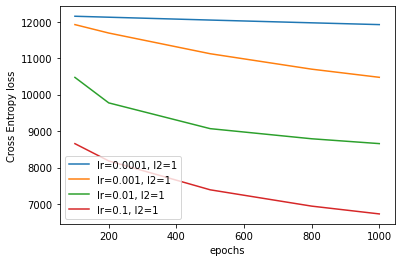

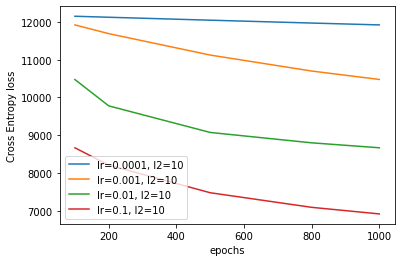

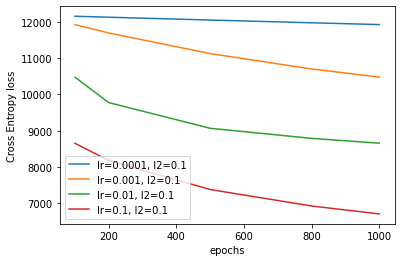

In [71]:
x_axis = [100,200,500,800,1000]

plt.plot(x_axis, loss_superset[0], label='lr=0.0001, l2=1')
plt.xlabel("epochs")
plt.ylabel("Cross Entropy loss")
plt.plot(x_axis, loss_superset[1], label='lr=0.001, l2=1')
plt.plot(x_axis, loss_superset[2], label='lr=0.01, l2=1')
plt.plot(x_axis, loss_superset[3], label='lr=0.1, l2=1')


plt.legend()
plt.show()

plt.xlabel("epochs")
plt.ylabel("Cross Entropy loss")
plt.plot(x_axis, loss_superset[4], label='lr=0.0001, l2=10')
plt.plot(x_axis, loss_superset[5], label='lr=0.001, l2=10')
plt.plot(x_axis, loss_superset[6], label='lr=0.01, l2=10')
plt.plot(x_axis, loss_superset[7], label='lr=0.1, l2=10')
plt.legend()
plt.show()

plt.xlabel("epochs")
plt.ylabel("Cross Entropy loss")
plt.plot(x_axis, loss_superset[8], label='lr=0.0001, l2=0.1')
plt.plot(x_axis, loss_superset[9], label='lr=0.001, l2=0.1')
plt.plot(x_axis, loss_superset[10], label='lr=0.01, l2=0.1')
plt.plot(x_axis, loss_superset[11], label='lr=0.1, l2=0.1')
plt.legend()
plt.show()



# Evaluation of Algorithm
## (Functions to be used for evaluation of Part 5 as well)

In [44]:
def evaluation_function(predicted_labels, actual_labels):
    # construct confusion matrix
    # report accuracy
    # report f1 score
    num_predictions = len(predicted_labels)
    correct_count = 0
    # constructing confusion matrix
    confusion_matrix = np.zeros((3,3))
    # 0 is negative, 1 is neutral, 2 is positive
    for i in range(num_predictions):
        if predicted_labels[i] == actual_labels[i]:
            correct_count += 1
        # confusion_matrix[predicted_labels[i]][actual_labels[i]] += 1
        confusion_matrix[predicted_labels[i], actual_labels[i]] += 1
    accuracy = correct_count/num_predictions

    # computing macro averages
    # computing recall
    recall_0 = confusion_matrix[0,0]/np.sum(confusion_matrix[:,0])
    recall_1 = confusion_matrix[1,1]/np.sum(confusion_matrix[:,1])
    recall_2 = confusion_matrix[2,2]/np.sum(confusion_matrix[:,2])

    # computing precision
    try:
        precision_0 = confusion_matrix[0,0]/np.sum(confusion_matrix[0])
    except:
        precision_0 = 0
    try:
        precision_1 = confusion_matrix[1,1]/np.sum(confusion_matrix[1])
    except:
        precision_1 = 0
    try:
        precision_2 = confusion_matrix[2,2]/np.sum(confusion_matrix[2])
    except: precision_2 = 0

    macro_avg_recall = (recall_0 + recall_1 + recall_2)/3
#     print(macro_avg_recall)
    macro_avg_precision = (precision_0 + precision_1 + precision_2)/3
#     print(macro_avg_precision)

    macro_f1_score = 2*macro_avg_recall*macro_avg_precision/(macro_avg_recall+macro_avg_precision)
    print('macro f1', macro_f1_score)
    print('accuracy', accuracy)
    print(confusion_matrix)
    return accuracy, confusion_matrix, macro_f1_score

In [46]:
# predictions_set1 = predict(test_bog, e1000_set1)
# print(list(set(e1000_set1[0])))
# print(list(set(e1000_set1[1])))
# print(list(set(e1000_set1[2])))
_,_, _ = evaluation_function(predictions_set1, encoded_test_labels)
# print(predictions_set1)

macro f1 0.4820779505250031
accuracy 0.64275956284153
[[923. 296. 223.]
 [  0.   3.   1.]
 [  1.   2.  15.]]


In [29]:
# encoding of the actual labels
encoded_train_labels = []
for label in train_sentiment:
    if label == 'positive':
        encoded_train_labels.append(2)
    elif label == 'neutral':
        encoded_train_labels.append(1)
    elif label == 'negative':
        encoded_train_labels.append(0)

encoded_test_labels = []
for label in test_sentiment:
    if label == 'positive':
        encoded_test_labels.append(2)
    elif label == 'neutral':
        encoded_test_labels.append(1)
    elif label == 'negative':
        encoded_test_labels.append(0)

In [55]:
def compute_loss(dataset, label_set, weight_vector):
    loss = 0
    for i in range(3):
        loss += cross_entropy_loss(label_set[i], dataset, weight_vector[i])
    return loss

In [57]:
loss1 = compute_loss(train_bog, label_set, e100_set1)
print(loss1)
loss2 = compute_loss(train_bog, label_set, e100_set2)
print(loss2)
loss3 = compute_loss(train_bog, label_set, e100_set3)
print(loss3)
loss4 = compute_loss(train_bog, label_set, e100_set4)
print(loss4)
loss5 = compute_loss(train_bog, label_set, e100_set5)
print(loss5)

9799.821360453887
8984.374609249742
8838.66759931274
17697.97377454303
9799.841363549089


# Part 4: Logistic Regression using Scikit-Learn

In [25]:
logistic_reg = LogisticRegression(multi_class='ovr', max_iter=1000)
logistic_reg.fit(train_bog, train_sentiment) 

LogisticRegression(max_iter=1000, multi_class='ovr')

The model is trained using the training bag of words as the input data, along with the labels passed as 'negative', 'positive', or 'neutral'.

In [26]:
predictions = logistic_reg.predict(test_bog)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
report = classification_report(test_sentiment, predictions)
con_mat = confusion_matrix(test_sentiment, predictions)
print(report)
print('Confusion Matrix:')
print('1. Negative, 2. Neutral 3. Positive - this is applicable for both rows and columns')
print(con_mat)

              precision    recall  f1-score   support

    negative       0.85      0.90      0.88       924
     neutral       0.60      0.59      0.60       301
    positive       0.80      0.62      0.70       239

    accuracy                           0.79      1464
   macro avg       0.75      0.70      0.72      1464
weighted avg       0.79      0.79      0.79      1464

Confusion Matrix:
1. Negative, 2. Neutral 3. Positive - this is applicable for both rows and columns
[[835  74  15]
 [102 178  21]
 [ 47  44 148]]


The confusion matrix has been plotted above. The accuracy comes out to be roughly 0.79. The macro average of the f1 score is 0.72, while the weighted average of the f1-score is 0.79. As can be seen, there is much more data available for the negative sentiment as compared to neutral and positive tweets. Furthermore, the f1 score is generally high for negative tweets as well, showing that the classifier performs generally better in that case.

Summary:
<br>
Accuracy: 0.79
<br>Macro Average F1-score: 0.72
<br>Weighted Average F1-score: 0.79

# Part 5: Implementation of Naive Bayes Classifier from scratch

In [37]:
# try with removing stop words and without removing stop words
# prepare the two bag of words
# already have one without the stop words

# need to apply laplace smoothing to the bag of words
# calculate prior probabilities

# training bag of words is train_bog
# testing bag of words is test_bog

In [36]:
# making one whole bag of words for training
NB_bow_neg = np.zeros((len(train_vocab)))
NB_bow_pos = np.zeros((len(train_vocab)))
NB_bow_neu = np.zeros((len(train_vocab)))
for tweet_index,tweet in enumerate(clean_train_tweets):
    tweet = tweet.split()
    for word in tweet:
        index = train_vocab.index(word)
        if train_sentiment[tweet_index] == 'negative':
            NB_bow_neg[index] += 1
        elif train_sentiment[tweet_index] == 'positive':
            NB_bow_pos[index] += 1
        elif train_sentiment[tweet_index] == 'neutral':
            NB_bow_neu[index] += 1


In [38]:
neg_total = np.sum(NB_bow_neg)
pos_total = np.sum(NB_bow_pos)
neu_total = np.sum(NB_bow_neu)

# add 1 smoothing
total_add = len(train_vocab)
neg_total += total_add
pos_total += total_add
neu_total += total_add

NB_bow_neg += 1
NB_bow_pos += 1
NB_bow_neu += 1

# calculating likelihood for each word
neg_likelihood = NB_bow_neg / neg_total
pos_likelihood = NB_bow_pos / pos_total
neu_likelihood = NB_bow_neu / neu_total

likelihood_matrix = []
likelihood_matrix.append(neg_likelihood)
likelihood_matrix.append(pos_likelihood)
likelihood_matrix.append(neu_likelihood)

In [39]:
positive = negative = neutral = 0
for sentiment in train_sentiment:
    if sentiment == 'positive':
        positive += 1
    elif sentiment == 'negative':
        negative += 1
    elif sentiment == 'neutral':
        neutral += 1
total_probs = positive + negative + neutral
positive = positive/total_probs
negative = negative/total_probs
neutral = neutral/total_probs

In [40]:
def naive_bayes_predictor(input_mat, vocab, likelihood_mat):
    predictions = []
    for tweet in input_mat:
        tweet = tweet.split()
        probs = [1,1,1]
        for word in tweet:
            try:
                word_index = vocab.index(word)
                probs[0] *= likelihood_mat[0][word_index]
                probs[1] *= likelihood_mat[2][word_index]
                probs[2] *= likelihood_mat[1][word_index]
            except:
                pass
        probs[0] *= negative
        probs[1] *= neutral
        probs[2] *= positive
        prediction = probs.index(max(probs))
        predictions.append(prediction)
    predictions = np.array(predictions)
    return predictions

In [47]:
predictions_NB = naive_bayes_predictor(clean_test_tweets, train_vocab, likelihood_matrix)
_ = evaluation_function(encoded_test_labels, predictions_NB)

macro f1 0.6674081427319486
accuracy 0.7602459016393442
[[899.  19.   6.]
 [182.  97.  22.]
 [102.  20. 117.]]


Compared to the performance achieved in Part 6, we can see that our Naive Bayes model performs exactly the same as the Naive Bayes classifier implemented by Scikit-Learn. The confusion matrix produced is the same, along with the accuracy and F1-scores achieved.

# Part 6: Scikit-Learn implementation of Naive Bayes Classifier

In [27]:
NB_skl_model = MultinomialNB()
NB_skl_model.fit(train_bog, train_sentiment, sample_weight=None) 

MultinomialNB()

In [28]:
NB_predictions = NB_skl_model.predict(test_bog)
nb_report = classification_report(test_sentiment, NB_predictions)
nb_con_mat = confusion_matrix(test_sentiment, NB_predictions)

print(nb_report)
print('Confusion Matrix')
print(nb_con_mat)

              precision    recall  f1-score   support

    negative       0.76      0.97      0.85       924
     neutral       0.71      0.32      0.44       301
    positive       0.81      0.49      0.61       239

    accuracy                           0.76      1464
   macro avg       0.76      0.59      0.64      1464
weighted avg       0.76      0.76      0.73      1464

Confusion Matrix
[[899  19   6]
 [182  97  22]
 [102  20 117]]


The results are relatively similar to the Logistic Regression model.

We have more data for negative tweets, and hence the prediction is generally stronger for them (as can be seen with the f1-score etc). However, the overall accuracy is generally about as good as it was for the logistic regression model. What we will also investigate is the effect of removing stop words. We will now run the model with the stop words included and evaluate performance. 


In [42]:
NB_skl_model_wsw = MultinomialNB()
NB_skl_model_wsw.fit(train_bog_wsw, train_sentiment, sample_weight=None) 

NB_predictions_wsw = NB_skl_model.predict(test_bog_wsw)
nb_report_wsw = classification_report(test_sentiment, NB_predictions_wsw)
nb_con_mat_wsw = confusion_matrix(test_sentiment, NB_predictions_wsw)

print(nb_report_wsw)
print('Confusion Matrix')
print(nb_con_mat_wsw)


              precision    recall  f1-score   support

    negative       0.76      0.97      0.85       924
     neutral       0.71      0.32      0.44       301
    positive       0.81      0.49      0.61       239

    accuracy                           0.76      1464
   macro avg       0.76      0.59      0.64      1464
weighted avg       0.76      0.76      0.73      1464

Confusion Matrix
[[899  19   6]
 [182  97  22]
 [102  20 117]]
